In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from collections import Counter

In [2]:
from latticeproteins.conformations import Conformations
from latticeproteins.sequences import RandomSequence
from latticeproteins.evolution import Evolution, AdaptiveWalk
from latticeproteins.fitness import Fitness

from latticegpm.gpm import LatticeGenotypePhenotypeMap
from latticegpm.search import sequence_space

from gpmap.evolve.models import fixation
from gpmap.evolve.mc import monte_carlo, EvolverError
from gpmap.utils import hamming_distance
from gpmap.graph.paths import paths_and_probabilities


from epistasis.models.linear import EpistasisLinearRegression
from epistasis.stats import magnitude_vs_order
from epistasis import plot

In [3]:
length = 15
temperature = 1.0
dGdependence= "fracfolded"
c = Conformations(length)

In [50]:
import math

In [52]:
math.factorial(13)

6227020800

In [4]:
wildtype = "".join(RandomSequence(length))
numsteps = 13
f = None
fitness = Fitness(temperature, c, dGdependence=dGdependence)
finalpop = AdaptiveWalk(wildtype, fitness, numsteps, file=f, steepest_ascent=True)
mutant = finalpop[0]
order = hamming_distance(wildtype, mutant)
print(order)
print('"'+wildtype+'", "'+mutant+'"')

5
"RLLHQMINLSNN", "HLFWQMINLSIF"


In [5]:
seq0, seq1 = wildtype, mutant #"QKRLGPCMWE", "FKDFDPCMKE"

In [6]:
out0 = c.FoldSequence(seq0, 1.0)
out1 = c.FoldSequence(seq1, 1.0)
conf0 = out0[1] 
conf1 = out1[1]

gpm = LatticeGenotypePhenotypeMap.from_mutant(seq0, seq1, c, temperature=1)
gpm.phenotype_type = "fracfolded"
gpm.phenotypes

array([ 0.06880361,  0.47899862,  0.15727223,  0.81545632,  0.13673206,
        0.68011839,  0.22473356,  0.89565296,  0.06775608,  0.57488666,
        0.15374051,  0.84791894,  0.07946072,  0.76987539,  0.15781729,
        0.93166118,  0.06655195,  0.46597121,  0.16125822,  0.85602532,
        0.15050456,  0.63521897,  0.23546868,  0.90039014,  0.07506411,
        0.56221258,  0.20513778,  0.89066189,  0.11559912,  0.73462357,
        0.25150675,  0.9390523 ])

In [38]:
import pickle

In [46]:
with open("scripts/results/test-no-z-0.pickle", "rb") as f:
    data = pickle.load(f)

In [49]:
data

Counter({(): 100})

In [8]:
# Calculate the temperature
fitness = Fitness(temperature, c, dGdependence=dGdependence)
temp = fitness.NativeE(gpm.genotypes[-1])/ gpm.stabilities[-1]

In [40]:
gpm2 = LatticeGenotypePhenotypeMap.from_mutant(seq0, seq1, c, target_conf=conf1, temperature=temp)
gpm2.phenotype_type = "fracfolded"
#gpm.nativeEs = gpm.nativeEs / gpm.nativeEs[-1]
gpm2.set_partition_confs([conf1, "RRRRRRRRRRRRRR"])
gpm2.phenotypes

array([ 0.7249775 ,  0.73129033,  0.74819543,  0.75415604,  0.76371991,
        0.76942628,  0.79411207,  0.79927735,  0.77182898,  0.77676264,
        0.79222518,  0.79683391,  0.8057399 ,  0.81012071,  0.83191667,
        0.83582744,  0.74173931,  0.75887469,  0.76400282,  0.78009896,
        0.7788408 ,  0.79419753,  0.80777752,  0.82158525,  0.78657594,
        0.80094962,  0.80598528,  0.81935199,  0.81880968,  0.83147759,
        0.84356721,  0.85481112])

In [41]:
paths = []
error = None
for i in range(100):
    try:
        paths.append(monte_carlo(gpm, gpm.wildtype, gpm.genotypes[-1], fixation, forward=True))
    except EvolverError as e:
        error = e
        paths.append(tuple())
z = Counter(paths)
print(len(z))
#print(z)
print(error)

17
None


/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


In [16]:
paths2 = []
error = None

for i in range(100):
    try:
        paths2.append(monte_carlo(gpm2, gpm2.wildtype, gpm2.genotypes[-1], fixation, forward=True))
    except EvolverError as e:
        error = e
        paths2.append(tuple())
y = Counter(paths2)
print(len(y))
print(error)

NameError: name 'gpm2' is not defined

In [43]:
paths = list(set(list(z.keys()) + list(y.keys())))

zbar = np.zeros(len(paths), dtype=float)
ybar = np.zeros(len(paths), dtype=float)

for i, p in enumerate(paths):
    if p in z:
        zbar[i] = z[p]
    if p in y:
        ybar[i] = y[p]

<Container object of 56 artists>

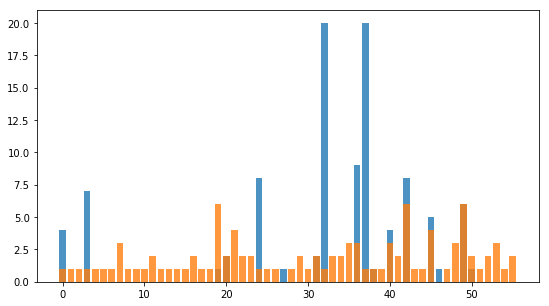

In [44]:
x = np.arange(len(zbar))
fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x, zbar, alpha=.8)
ax.bar(x, ybar, alpha=.8)

In [45]:
from gpmap.graph.paths import flux
from gpmap.graph import draw

/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


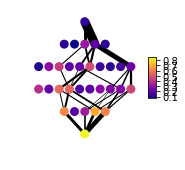

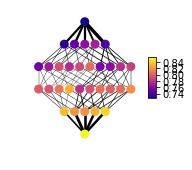

In [46]:
gpm.add_networkx()
gpm2.add_networkx()
source, target = 0, 31 

fluxes2 = flux(gpm.Graph, source, target, transition_model=fixation)
fluxes5 = flux(gpm2.Graph, source, target, transition_model=fixation)

width=12

#vmax = max([max(ml_nonlinear.phenotypes),max(ml_nonlinear_2nd.phenotypes)])
#vmin = min([min(ml_nonlinear.phenotypes),min(ml_nonlinear_2nd.phenotypes)])
#print(round(vmax,2), round(vmin,2))
settings = dict(
    figsize=[2.5,2.5], 
    n_height=9, 
    n_width=9,
    n_linewidths=0,
    #n_vmax=round(vmax,2),
    #n_vmin=round(vmin,2),
    e_arrows=False, 
    l_alpha=0.0,
    n_colorbar=True
)  

fig, ax, pos = draw.network(gpm.Graph, e_width = width*fluxes2, **settings)
#fig.savefig("../img/network-"+dataset+"-2nd-order.pdf", format="pdf")
fig, ax, pos = draw.network(gpm2.Graph, e_width = width*fluxes5, **settings)
#fig.savefig("../img/network-"+dataset+"-5th-order.pdf", format="pdf")